In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json
Saving metadata.json to metadata.json


{'kaggle.json': b'{"username":"aamiransari072","key":"b413cdaf2ffe58b544094ed73febbabd"}',
 'metadata.json': b'{"aagfhgtpmv.mp4":{"label":"FAKE","split":"train","original":"vudstovrck.mp4"},"aapnvogymq.mp4":{"label":"FAKE","split":"train","original":"jdubbvfswz.mp4"},"abarnvbtwb.mp4":{"label":"REAL","split":"train","original":null},"abofeumbvv.mp4":{"label":"FAKE","split":"train","original":"atvmxvwyns.mp4"},"abqwwspghj.mp4":{"label":"FAKE","split":"train","original":"qzimuostzz.mp4"},"acifjvzvpm.mp4":{"label":"FAKE","split":"train","original":"kbvibjhfzo.mp4"},"acqfdwsrhi.mp4":{"label":"FAKE","split":"train","original":"ccfoszqabv.mp4"},"acxnxvbsxk.mp4":{"label":"FAKE","split":"train","original":"fjlyaizcwc.mp4"},"acxwigylke.mp4":{"label":"FAKE","split":"train","original":"ffcwhpnpuw.mp4"},"aczrgyricp.mp4":{"label":"FAKE","split":"train","original":"slwkmefgde.mp4"},"adhsbajydo.mp4":{"label":"FAKE","split":"train","original":"fysyrqfguw.mp4"},"adohikbdaz.mp4":{"label":"FAKE","split":"

In [ ]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c deepfake-detection-challenge

100% 4.13G/4.13G [00:37<00:00, 117MB/s] 
100% 4.13G/4.13G [00:37<00:00, 117MB/s]


In [ ]:
!mkdir deep_fake

mkdir: cannot create directory ‘deep_fake’: File exists


In [ ]:
%%capture
!unzip deepfake-detection-challenge.zip -d deep_fake

In [ ]:
import pandas as pd
import json

# Load the JSON data
with open('metadata.json', 'r') as file:
    data = json.load(file)

# Convert the data into a list of dictionaries
metadata_list = [{'filename': key, **value} for key, value in data.items()]

# Create a DataFrame from the list
df = pd.DataFrame(metadata_list)

# Display the DataFrame
df.tail()


,filename,label,split,original
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
398,eudeqjhdfd.mp4,REAL,train,None
399,eukvucdetx.mp4,FAKE,train,gjypopglvi.mp4


In [ ]:
df['label'].value_counts()

label
FAKE    323
REAL     77
Name: count, dtype: int64

In [ ]:
data = df.drop(['split','original'],axis=1)

In [ ]:
import os

path ='/content/deep_fake/train_sample_videos'

data['filename'] = data['filename'].apply(lambda x: os.path.join(path, x))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  400 non-null    object
 1   label     400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


In [ ]:
data['label'] = data['label'].apply(lambda x: 0 if x == 'REAL' else 1)

In [ ]:
data['label'].value_counts()

label
1    323
0     77
Name: count, dtype: int64

In [ ]:
data

,filename,label
0,/content/deep_fake/train_sample_videos/aagfhgt...,1
1,/content/deep_fake/train_sample_videos/aapnvog...,1
2,/content/deep_fake/train_sample_videos/abarnvb...,0
3,/content/deep_fake/train_sample_videos/abofeum...,1
4,/content/deep_fake/train_sample_videos/abqwwsp...,1
...,...,...
395,/content/deep_fake/train_sample_videos/etejaap...,1
396,/content/deep_fake/train_sample_videos/etmcrua...,1
397,/content/deep_fake/train_sample_videos/etohcvn...,1
398,/content/deep_fake/train_sample_videos/eudeqjh...,0


In [ ]:
def preprocess_frame(frame):
  resized_frame = cv2.resize(frame, (224, 224))
  normalized_frame = resized_frame.astype('float32') / 255.0
  return normalized_frame

In [ ]:
import cv2
import os

def extract_preprocess_frames(video_path, label, save_dir):
  """Extracts, preprocesses frames from a video, saves them, and returns paths with labels.

  Args:
      video_path (str): Path to the video file.
      label (str): Label for the video (e.g., "real", "deepfake").
      save_dir (str): Directory to save the extracted frames.

  Returns:
      list: List of tuples containing frame paths and their corresponding labels.
  """

  cap = cv2.VideoCapture(video_path)
  frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  processed_frames = []
  frame_index = 0


  if not os.path.exists(save_dir):
    os.makedirs(save_dir)

  while (frame_index < frames_count):
    ret, frame = cap.read()
    if ret:
      processed_frame = preprocess_frame(frame)


      filename = f"{os.path.basename(video_path)}_{label}_{frame_index}.jpg"
      save_path = os.path.join(save_dir, filename)

      cv2.imwrite(save_path, processed_frame)
      processed_frames.append((save_path, label))
      frame_index += 3
    else:
      break
  cap.release()

  return processed_frames

In [ ]:
def process_video_data(video_data_df, save_dir):
  """Processes video data in a DataFrame, extracts frames, and creates a new DataFrame.

  Args:
      video_data_df (pandas.DataFrame): DataFrame containing video information.
      save_dir (str): Directory to save the extracted frames.

  Returns:
      pandas.DataFrame: New DataFrame with columns for frame paths and labels.
  """

  all_frames = []
  for index, row in video_data_df.iterrows():
    video_path = row["filename"]
    label = row["label"]
    processed_frames = extract_preprocess_frames(video_path, label, save_dir)
    all_frames.extend(processed_frames)

  new_df = pd.DataFrame(all_frames, columns=["frame_path", "label"])
  return new_df

In [ ]:
!mkdir extracted_frames

In [ ]:
save_dir = "/content/extracted_frames"
all_frames_df = process_video_data(data, save_dir)

In [ ]:
all_frames_df

,frame_path,label
0,/content/extracted_frames/aagfhgtpmv.mp4_1_0.jpg,1
1,/content/extracted_frames/aagfhgtpmv.mp4_1_3.jpg,1
2,/content/extracted_frames/aagfhgtpmv.mp4_1_6.jpg,1
3,/content/extracted_frames/aagfhgtpmv.mp4_1_9.jpg,1
4,/content/extracted_frames/aagfhgtpmv.mp4_1_12.jpg,1
...,...,...
39995,/content/extracted_frames/eukvucdetx.mp4_1_285...,1
39996,/content/extracted_frames/eukvucdetx.mp4_1_288...,1
39997,/content/extracted_frames/eukvucdetx.mp4_1_291...,1
39998,/content/extracted_frames/eukvucdetx.mp4_1_294...,1


In [ ]:
all_frames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   frame_path  40000 non-null  object
 1   label       40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
all_frames_df['label'].value_counts()

label
1    32300
0     7700
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_df , test_df = train_test_split(all_frames_df,test_size=0.3,random_state=42)

In [ ]:
print(f"Train df shape:{train_df.shape}")
print(f"Test df shape:{test_df.shape}")

Train df shape:(28000, 2)
Test df shape:(12000, 2)


In [ ]:
train_df['label'].value_counts()


label
1    22535
0     5465
Name: count, dtype: int64

In [ ]:
import cv2
from tensorflow.keras.applications import VGG16  # Replace with your chosen pre-trained CNN
from tensorflow.keras.layers import Flatten, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image loading and augmentatio

In [ ]:
img_height = 224
img_width =224

In [ ]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:

def create_data_generator(dataframe, batch_size, target_size=(img_height, img_width)):
  """
  Creates an image data generator from a DataFrame containing image paths and labels.

  Args:
      dataframe (pandas.DataFrame): The DataFrame containing image paths and labels.
      batch_size (int): The number of images to process together in each batch.
      target_size (tuple, optional): The desired height and width for resizing images. Defaults to (img_height, img_width).

  Returns:
      ImageDataGenerator: The created image data generator object.
  """

  # Get image paths and labels from the DataFrame (adjust column names if needed)
  image_paths = dataframe["frame_path"].tolist()
  labels = dataframe["label"].tolist()

  datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

  # Use flow_from_dataframe to load images and labels from the DataFrame
  generator = datagen.flow_from_dataframe(
      dataframe=dataframe,
      directory=None,
      x_col="frame_path",
      y_col="label",
      target_size=target_size,
      batch_size=batch_size,
      class_mode='binary'
  )

  return generator




In [ ]:
batch_size=128
train_generator = create_data_generator(train_df, batch_size=batch_size)
validation_generator = create_data_generator(test_df, batch_size=batch_size)


Found 28000 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


In [ ]:

# Load pre-trained ResNet model (replace with your specific version)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout , Conv2D,MaxPooling2D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Reshape, Flatten



base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model (optional, adjust based on fine-tuning strategy)
base_model.trainable = False

# Create the new model on top
inputs = Input(shape=(img_height, img_width, 3))

# No Rescaling layer needed if ImageDataGenerator rescaled to (0, 1)
x = base_model(inputs, training=False)
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu')(x)  # Corrected the typo here
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Reshape((1, x.shape[-1]))(x)
lstm_out = Bidirectional(LSTM(units=128, return_sequences=False))(x)
outputs = Dense(1, activation='sigmoid')(lstm_out)

model = Model(inputs, outputs)

model.summary(show_trainable=True)



94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50 (Functional)       (None, 7, 7, 2048)        2358771   N          
                                                       2                    
                                                                            
 conv2d (Conv2D)             (None, 6, 6, 64)          524352    Y          
                                                                            
 max_pooling2d (MaxPooling2  (None, 3, 3, 64)          0         Y          
 D)                                                                         
                                                                         

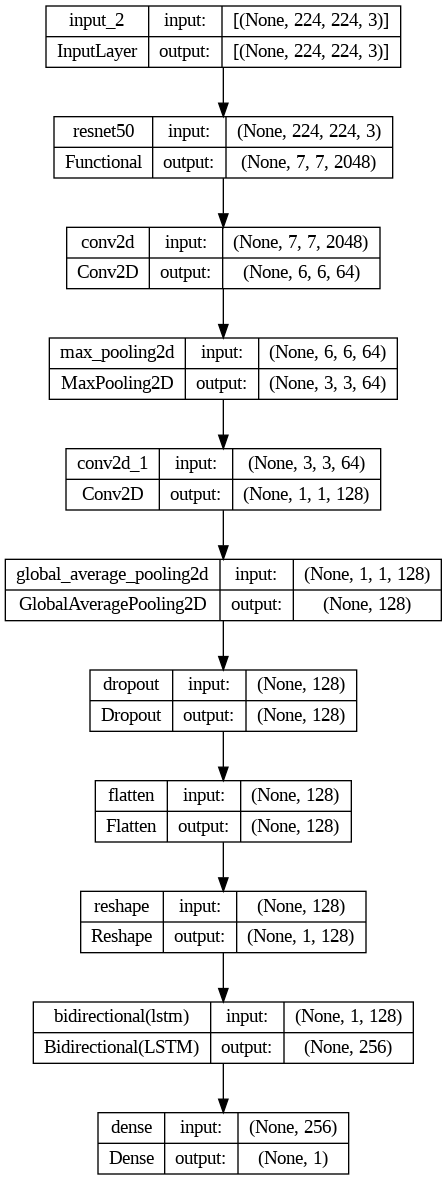

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator)



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


218/218 [==============================] - 612s 3s/step - loss: 0.4978 - accuracy: 0.8032 - val_loss: 0.4811 - val_accuracy: 0.8138
Epoch 2/5
218/218 [==============================] - 583s 3s/step - loss: 0.4954 - accuracy: 0.8048 - val_loss: 0.4816 - val_accuracy: 0.8138
Epoch 3/5
218/218 [==============================] - 562s 3s/step - loss: 0.4946 - accuracy: 0.8046 - val_loss: 0.4807 - val_accuracy: 0.8138
Epoch 4/5
218/218 [==============================] - 594s 3s/step - loss: 0.4942 - accuracy: 0.8047 - val_loss: 0.4823 - val_accuracy: 0.8138
Epoch 5/5
218/218 [==============================] - 567s 3s/step - loss: 0.4945 - accuracy: 0.8046 - val_loss: 0.4822 - val_accuracy: 0.8138


In [ ]:
model.save('my_model.keras')

In [ ]:
import tensorflow as tf

new_model=tf.keras.models.load_model('my_model.keras')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 64)          524352    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                     

In [ ]:
loaded_model = tf.keras.models.load_model('my_model.keras')

In [ ]:
import pickle

In [ ]:
with open('model_pickle','wb') as f:
  pickle.dump(model,f)

In [ ]:
with open('model_pickle','rb') as f:
  mp=pickle.load(f)

In [ ]:
# mp.predict()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 64)          524352    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                     